# Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

# Описание данных
- Данные лежат в файле /datasets/taxi.csv.
- Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 1.0 Подготовка

In [3]:
# Откроем таблицу двумя путями
server_data = '/datasets/taxi.csv'
local_data = '/Users/mmaximmaximovgmail.com/Desktop/DS/project 12/taxi.csv'

try:
    taxi = pd.read_csv(server_data, index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv(local_data, index_col=[0], parse_dates=[0])

In [4]:
# Делаю первичный анализ данных
display(taxi.head())
display(taxi.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

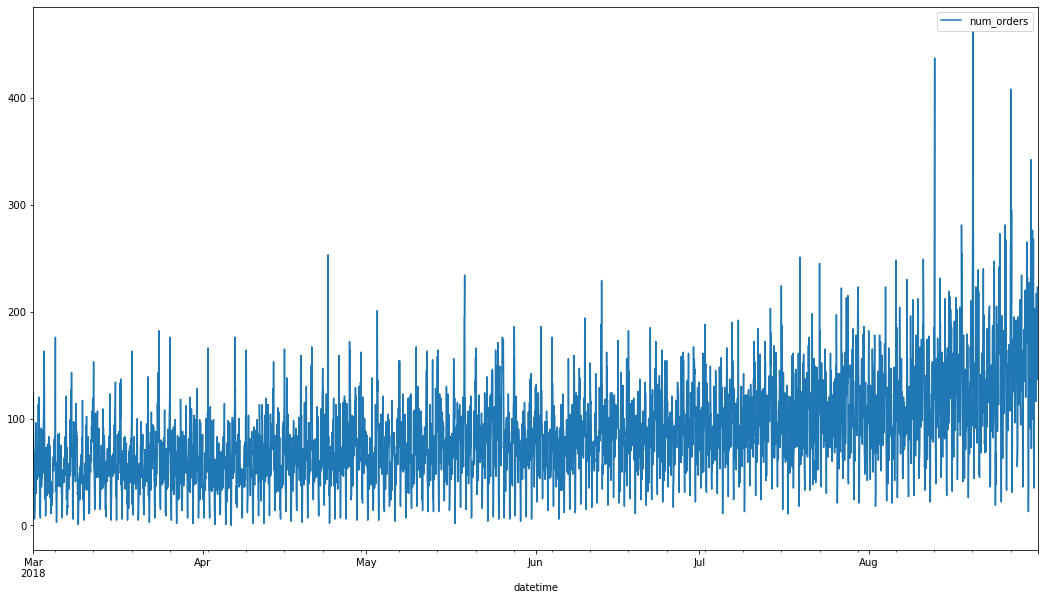

In [5]:
# Выполнил ресамплинг по 1 часу и строю график
tax_res = taxi.resample('1H').sum()
display(tax_res.head())
display(tax_res.plot(
    figsize = (18, 10)
))

### Мини-вывод 1.0:
- С данными в таблице все в порядке.
- Выполнил ресамплинг по 1 часу, до этого было каждые 10 минут и построил график.
- На первый вид график иммет стационарный вид, т.е не меняется со временем. Но начиная с лета график начал идти вверх.
- В следующем пункте подробней разберу к какому ряду относится график.

# 2.0 Анализ

Text(0.5, 1.0, 'Residuals')

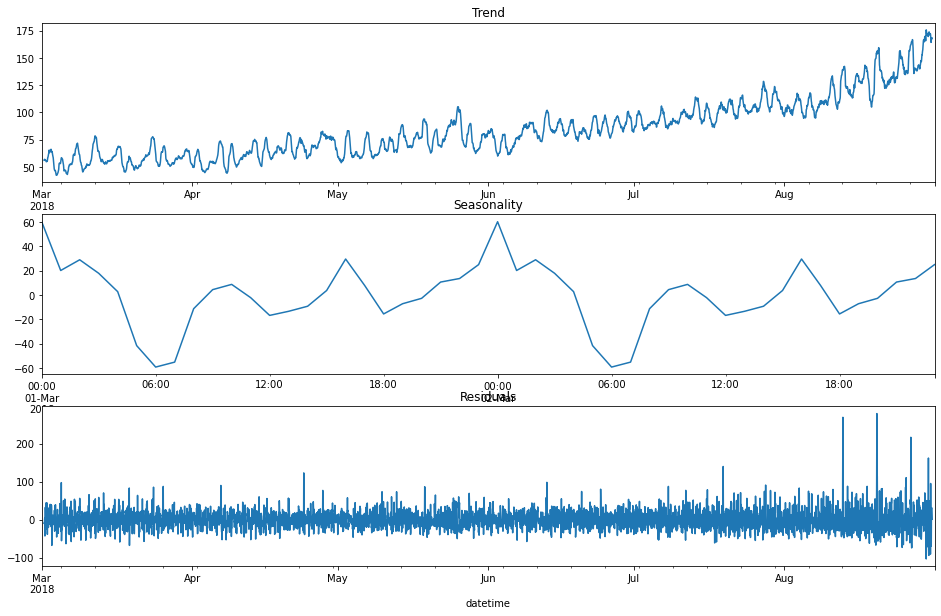

In [6]:
# Сначала посмотрю три графика: тренд, сезонность и остаток
# Для сезонна возьмем период одного дня
decomposed = seasonal_decompose(tax_res)
plt.figure(figsize=(16, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

# Мини-вывод 2.0:
- По графику тренд, видно чем ближе подходит к лету, тем выше становится спрос. Очень интересно, что происходит после лето.
- График Seasonality показываю в какие часы чаще заказывают такси:  чаще всего это в 12 часов ночи и меньше всего в 6 утра.

# 3.0 Обучение

In [7]:
# Начну с создания признака, дальше обучающая и тестовая выборка и после этого буду обучать модели
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [8]:
# Сделаю копию
taxis = tax_res.copy()

RMSE наилучшей модели на валидационной выборке: 14.745448486562386 Количество деревьев: 12 Максимальная глубина: 11


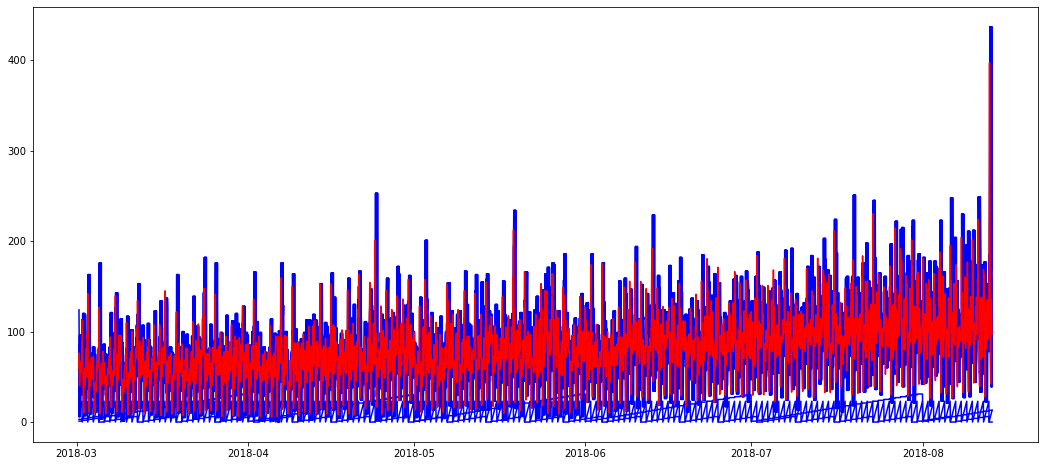

CPU times: user 6.57 s, sys: 20.8 ms, total: 6.59 s
Wall time: 6.61 s


In [9]:
%%time
# Лес
make_features(taxis, 10, 10)

train, test = train_test_split(taxis, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
Y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
Y_test = test['num_orders']

best_model = None
best_result = 10000
best_est = 0
best_depth = 0

for est in range(5, 13):
    for depth in range(1, 12):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(X_train, Y_train)
        predictions_valid = model_rf.predict(X_train)
        result = mean_squared_error(Y_train, predictions_valid) ** 0.5
        if result < best_result:
            best_model = model_rf
            best_result = result
            best_est = est
            best_depth = depth
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

plt.figure(figsize=(18,8))
plt.plot(X_train.index, 
         X_train, 
         'b', 
         X_train.index, 
         predictions_valid,
         'r')
plt.show()

In [10]:
train, test = train_test_split(taxis, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
Y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
Y_test = test['num_orders']

model = RandomForestRegressor()
param_search = {
    'max_depth' : [1, 100],
    'n_estimators' : [1, 100]
}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search)
gsearch.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 100], 'n_estimators': [1, 100]})

Значение RMSE: 31.09902993359831


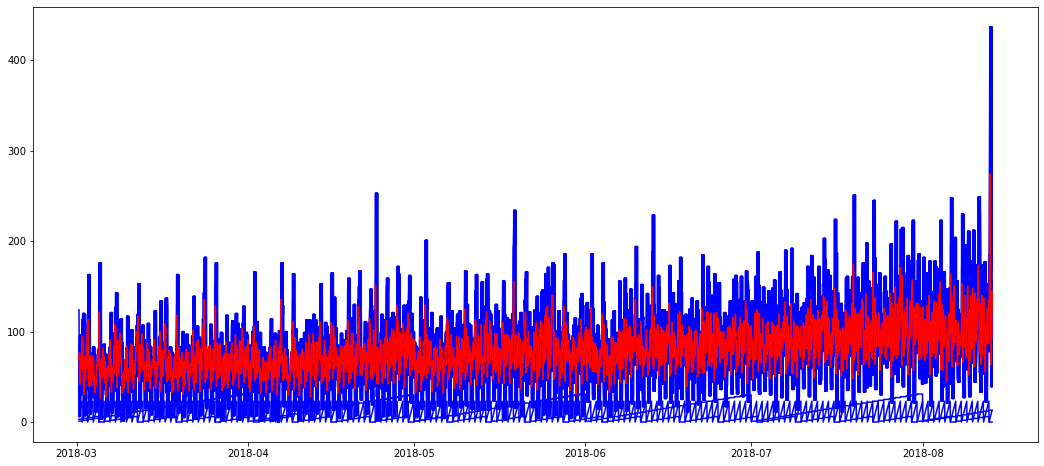

In [11]:
# Модель LinearRegression
make_features(taxis, 2, 2)
train, test = train_test_split(taxis, shuffle=False, test_size=0.1)
train = train.dropna()

A_train = train.drop('num_orders', axis=1)
B_train = train['num_orders']

A_test = test.drop('num_orders', axis=1)
B_test = test['num_orders']

model_lr = LinearRegression()
model_lr.fit(A_train, B_train)
pre = model_lr.predict(A_train)
result = mean_squared_error(pre, Y_train) ** 0.5
print('Значение RMSE:', result)

plt.figure(figsize=(18,8))
plt.plot(A_train.index, 
         A_train, 
         'b', 
         A_train.index, 
         pre,
         'r')
plt.show()

# 4.0 Тестирование

Тестовое значение RMSE: 45.590289933264245


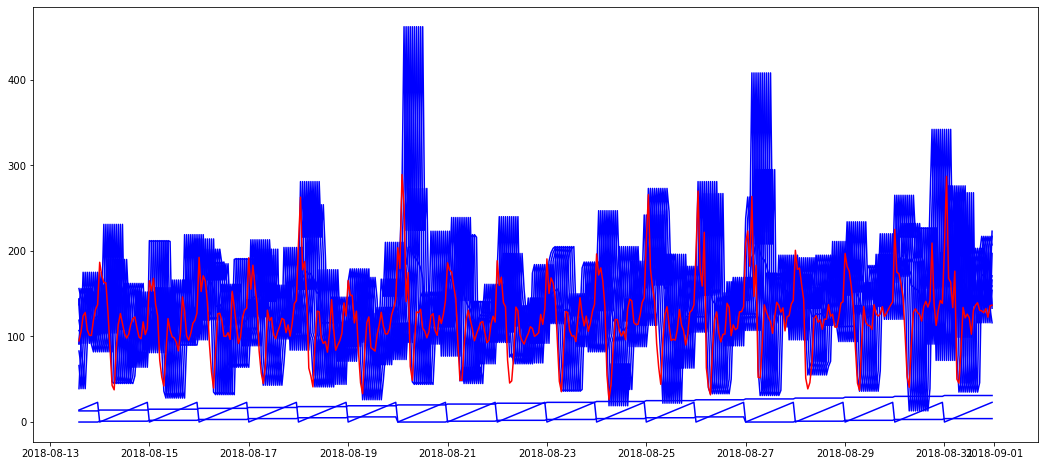

In [12]:
# Тестовая для gsearch
pre_test = gsearch.predict(X_test)

print("Тестовое значение RMSE:", mean_squared_error(pre_test, Y_test) ** 0.5)
plt.figure(figsize=(18,8))
plt.plot(X_test.index, 
         X_test, 
         'b', 
         X_test.index, 
         pre_test,
         'r')
plt.show()

Тестовое значение RMSE: 53.91555378008155


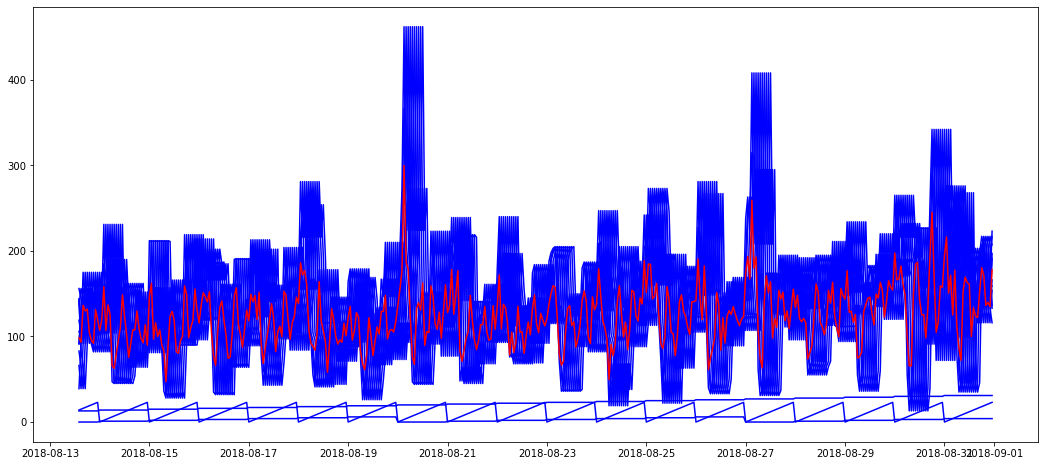

In [13]:
# Тестовая для линейной регрессии
pre_test = model_lr.predict(A_test)

print("Тестовое значение RMSE:", mean_squared_error(pre_test, B_test) ** 0.5)
plt.figure(figsize=(18,8))
plt.plot(A_test.index, 
         A_test, 
         'b', 
         A_test.index, 
         pre_test,
         'r')
plt.show()

# 5.0 Вывод
- Была проведенна работа по прогнозированию заказов такси на следующий час.
- В данных ошибок нет.
- Сделал ресамплинг по 1 часу в данных.
- Выяснил к началу лета график начинает расти.
- Чаще всего такси заказывают по ночам, реже всего по утрам.
- Создал две модели: линейная регрессия и лес.
- По итоговой тестовой выборке, выграла gsearch со значением: 45.78